# Evaluating Caution

Here, we aim to study when 'caution' (that is, higher inertia) is good or bad for convergence to team-optimality. We do this by generating the set of best-reply graphs for teams of a certain size and testing the effects of caution on the probability of absorption into an equilibrium for each. 

**Hypothesis:** A team's best-reply graph is determined by the order of $J(\pi)$ for each $\pi \in \Pi$. Then, a policy is a best-reply to another policy if its expected cost $J$ is lower, and it only differs in one agent.

In [2]:
import itertools
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

from sympy import *
from sympy.interactive import printing
from IPython.display import Math, display


import sys
sys.path.append('..')
from br_graph_analysis import learn_br_graph, transition_matrix_from_br_graph
import br_graph_analysis

In [3]:
def agent_distance(pi1, pi2):
    '''computes the number of agents in which the policies differ'''
    
    dist = 0
    
    for agent_policy1, agent_policy2 in zip(pi1, pi2):
        if agent_policy1 != agent_policy2:
            dist += 1
    
    return dist

In [4]:
def get_deviating_agent(pi1, pi2):
    '''if policies have a single deviating agent, returns that agent'''
    
    assert(agent_distance(pi1, pi2) == 1)
    
    for agent, (agent_policy1, agent_policy2) in enumerate(zip(pi1, pi2)):
        if agent_policy1 != agent_policy2:
            return agent

In [5]:
def gen_adj_matrix(jp_order, jp_dict):
    '''generates the best-reply graph from the order of joint policies'''
    
    n_policies = len(jp_dict)
    inv_jp_dict = {jp: ind for ind, jp in jp_dict.items()}
    
    # initialize adjacency matrix
    adjacency_matrix = np.zeros((n_policies, n_policies))

    for rank, jp1 in enumerate(jp_order):
        # if cost of jp2 is worse, and agent distance is 1
        for jp2 in jp_order[rank:]:
            if agent_distance(jp1, jp2) == 1:
                jp1_ind = inv_jp_dict[jp1]
                jp2_ind = inv_jp_dict[jp2]
                
                # add an edge
                adjacency_matrix[jp2_ind][jp1_ind] = 1
    
    return adjacency_matrix

In [6]:
def gen_graph_from_adj_matrix(adj_matrix, jp_dict):
    '''generates a networkx Digraph from adjacency matrix with nodes labelled'''
    
    # get joint policy space from jp_dict
    joint_policy_space = list(jp_dict.values())

    # initialize the best-reply graph and add its nodes
    br_graph = nx.DiGraph()
    br_graph.add_nodes_from(joint_policy_space)
    
    # get the directed edges in the graph from the adjacency matrix 
    edges = np.where(adj_matrix == 1)
    
    # add all edges to graph (with attribute for deviating agent)
    for jp_from_ind, jp_to_ind in zip(*edges):
        jp_from = jp_dict[jp_from_ind]
        jp_to = jp_dict[jp_to_ind]
        deviating_agent = get_deviating_agent(jp_from, jp_to)
        
        br_graph.add_edge(jp_from, jp_to, agent=deviating_agent)
    
    return br_graph

In [7]:
def gen_br_graph_space(jp_dict):
    '''generates the space of valid best-reply graphs through all possible orderings of joint policy space'''

    # get joint policy space from jp_dict
    joint_policy_space = list(jp_dict.values())
    
    # initialize best-reply graph space
    br_graph_space = []
    
    # for each permuation of joint policies, generate best-reply graph
    # and add it the space
    for perm in tqdm(itertools.permutations(range(len(joint_policy_space)))):
        jp_order = [jp_dict[i] for i in perm]
        adj_matrix = gen_adj_matrix(jp_order, jp_dict)
        br_graph = gen_graph_from_adj_matrix(adj_matrix, jp_dict)
        
        br_graph_space.append((jp_order, br_graph))

    return br_graph_space

In [8]:
def draw_br_graph_grid(br_graph_space, jp_dict, inch_per_rowcol=4):
    '''draws a grid of all the best-reply graphs in the given space'''
    
    inv_jp_dict = {jp: ind for ind, jp in jp_dict.items()}
    
    ncols = int(np.sqrt(len(br_graph_space)))
    nrows = len(br_graph_space) // ncols + int((len(br_graph_space) % ncols) > 0)
    figsize = (ncols*inch_per_rowcol, nrows*inch_per_rowcol)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.ravel()

    for ax, (jp_order, br_graph) in zip(axs, br_graph_space):
        node_colors = ['tab:blue']*len(jp_order)
        team_optimal_policy_ind = inv_jp_dict[jp_order[0]]
        node_colors[team_optimal_policy_ind] = 'tab:green'
        nx.draw_spectral(br_graph, ax=ax, with_labels=True, arrowsize=40, edge_color='tab:grey', node_color=node_colors)
    
    return fig, axs

In [28]:
def get_team_opt_prob(team_opt_policy, br_graph, jp_dict, return_all=False):
    '''gets symbolic expression for the probability of being absorbed into the team-optimal policy'''
    
    inv_jp_dict = {jp: ind for ind, jp in jp_dict.items()}
    
    
    # indices of absorbing states, transient states, and the team-optimal state
    abs_states = [inv_jp_dict[node] for node in br_graph.nodes if br_graph.out_degree(node) == 0]
    trans_states = [i for i in range(len(joint_policy_space)) if i not in abs_states]
    team_opt = inv_jp_dict[team_opt_policy]

    # reorder abs_states so that team-optimal state is at the end
    abs_states.remove(team_opt)
    abs_states.append(team_opt)
    
    # create inertia symbolic variables
    agent_inertias = symbols(f'lambda_0:{n_agents}')

    # get transition matrix of Markov chain from best-reply graph
    P_, jps_dict = transition_matrix_from_br_graph(br_graph, agent_inertias, joint_policy_space)

    # calculate Q and R submatrices according absorbing Markov chain tools
    Q_ = P_[trans_states][:, trans_states]
    Q = Matrix(Q_).applyfunc(nsimplify)

    R_ = P_[trans_states][:, abs_states]
    R = Matrix(R_).applyfunc(nsimplify)

    # get the transition matrix in absorbing canonical form
    reorder = trans_states + abs_states
    P_ro_ = P_[reorder][:, reorder]
    P_ro = Matrix(P_ro_).applyfunc(nsimplify)

    # calculate the fundamental matrix N
    Id = Matrix(np.eye(Q.shape[0])).applyfunc(nsimplify)
    N = simplify((Id - Q).adjugate() / (Id - Q).det()) 
    
    # calculate the absorbing matrix B
    B = simplify(N@R)

    # calculate P_inf in absorbing canonical form
    left_side = np.zeros((len(abs_states) + len(trans_states), len(trans_states)))
    right_side = np.vstack((B, np.eye(len(abs_states))))
    P_inf_can = Matrix(np.hstack((left_side, right_side))).applyfunc(nsimplify)
    
    # calculate the final distribution of states assuming uniform random initialization
    uniform_dist = Matrix([1/len(joint_policy_space)]*len(joint_policy_space)).T
    final_dist = simplify(Matrix(uniform_dist @ P_inf_can))
    
    # calculate the absorbtion probability of the team-optimal policy
    team_opt_prob = final_dist[-1]
    
    if return_all:
        return agent_inertias, team_opt_prob, (P_ro, Q, R, N, B, P_inf_can)
    
    return agent_inertias, team_opt_prob

## Evaluating Caution in 2-agent repeated games with 2 actions

Let's start with a simple repeated game with two agents, and 2 actions for each agent.

In [10]:
n_agents = 2
n_states = 1
n_actions = 2
n_Us = [n_actions] * n_agents # number of actions per agent (both agents have two actions)


agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))
jp_dict = {i: jp for i,jp in enumerate(joint_policy_space)}

Generate the space of 'valid' best-reply graphs and plot it. Recall that we generate this set through all permuations of orderings of the joint policy space. A joint policy is a best-reply to another if it has lower cost $J$, and only differs in one agent. The team optimal policy is colored in green.

Note: for now, we don't consider cases where the expected cost $J$ for two policies is exactly the same.

In [11]:
br_graph_space = gen_br_graph_space(jp_dict)

24it [00:00, 12009.46it/s]


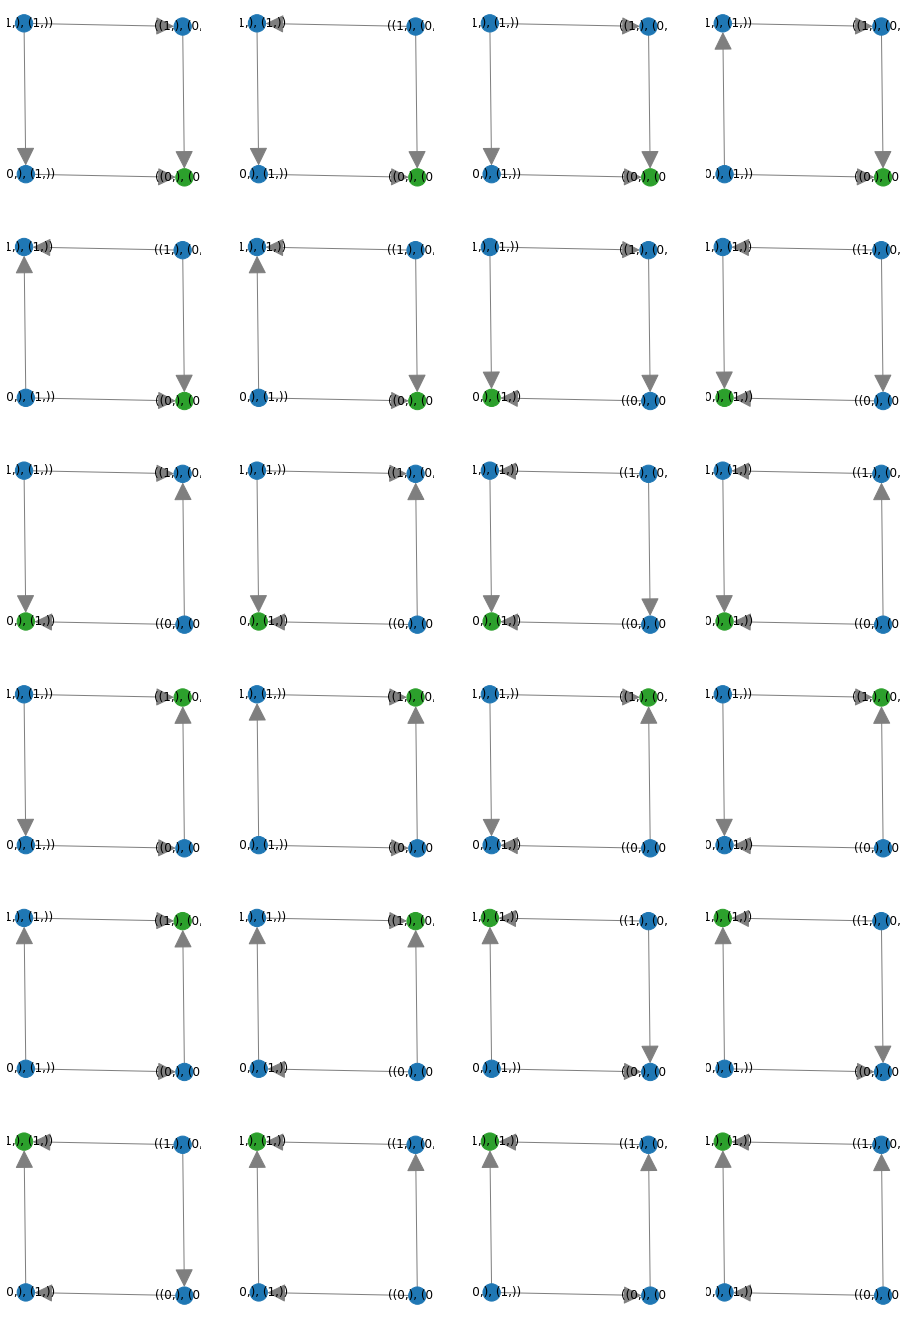

In [12]:
draw_br_graph_grid(br_graph_space, jp_dict);

We test each best-reply graph to see if caution helps or hinders convergence to team-optimality. Here, we plot the probability of being absorbed into the team-optimal policy as a function of inertia (constant over all agents).

24it [00:11,  2.13it/s]


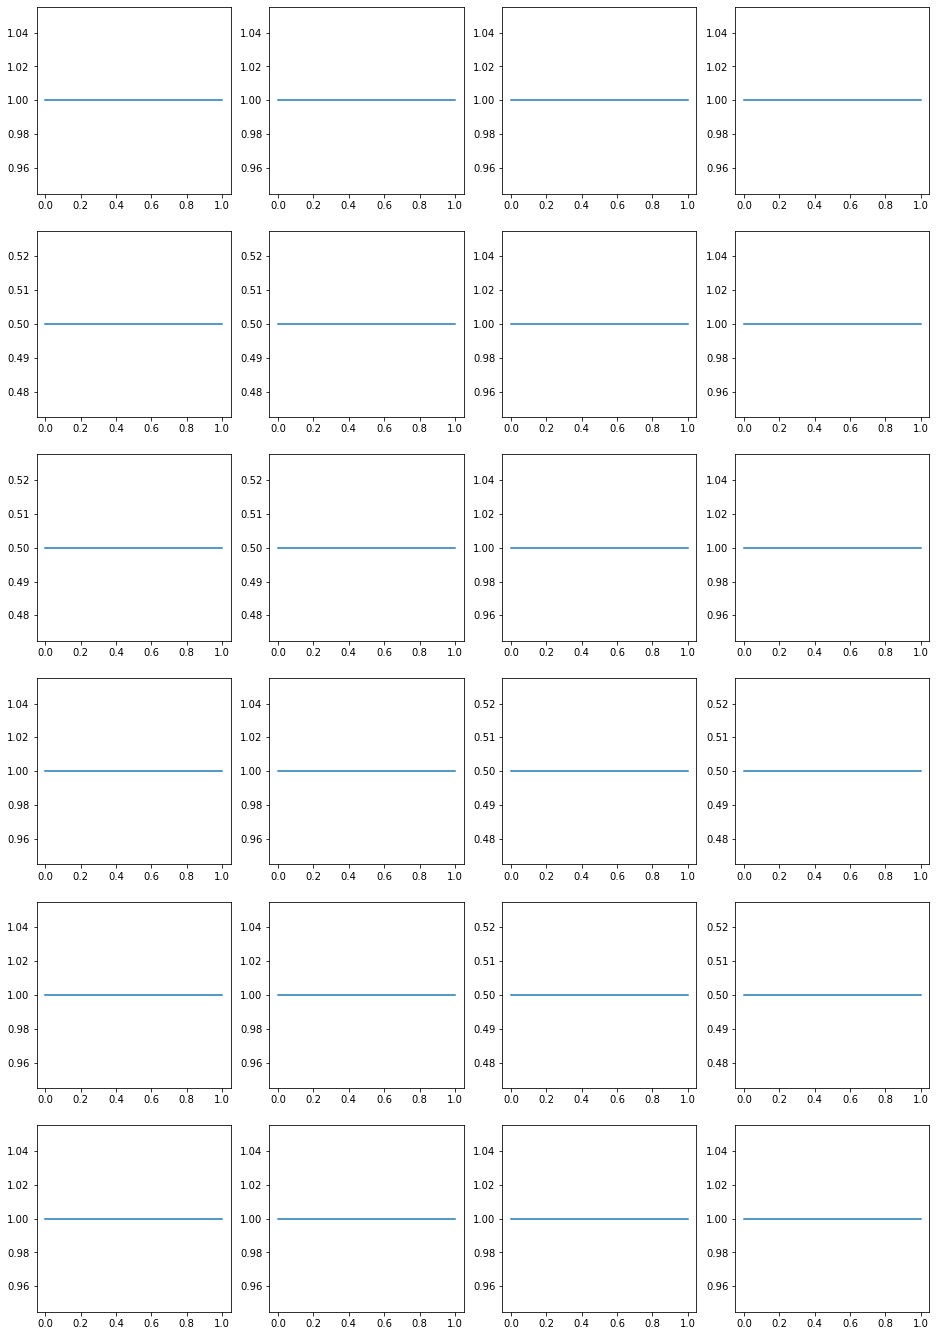

In [13]:
inv_jp_dict = {jp: ind for ind, jp in jp_dict.items()}

ncols = int(np.sqrt(len(br_graph_space)))
nrows = len(br_graph_space) // ncols + int((len(br_graph_space) % ncols) > 0)
figsize = (ncols*4, nrows*4)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
axs = axs.ravel()

epsilon = 1e-3

for ax, (jp_order, br_graph) in tqdm(zip(axs, br_graph_space)):
    team_opt_policy = jp_order[0]
    agent_inertias, team_opt_prob = get_team_opt_prob(team_opt_policy, br_graph, jp_dict, return_all=False)
    
    Lambdas = np.linspace(epsilon, 1 - epsilon, num=100)
    team_opt_probs = [team_opt_prob.subs(zip(agent_inertias, [l]*n_agents)) for l in Lambdas]
    
    ax.plot(Lambdas, team_opt_probs)


Note that for this class of repeated teams, the inertia parameter has no effect on the absorption probability. It is either constant $1/2$ or $1$ depending on the number of equilibria.

## Evaluating caution in 3-agent repeated games with 2 actions

The number of possible best-reply graphs here is $8! = 40,320$, which is much larger!

In [29]:
n_agents = 3
n_states = 1
n_actions = 2
n_Us = [n_actions] * n_agents # number of actions per agent (both agents have two actions)


agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))
jp_dict = {i: jp for i,jp in enumerate(joint_policy_space)}

We compute the best-reply graph space

In [30]:
br_graph_space = gen_br_graph_space(jp_dict)

40320it [00:07, 5216.86it/s]


and plot a sample of the graphs (we can't plot all $8!$ of them ;p)

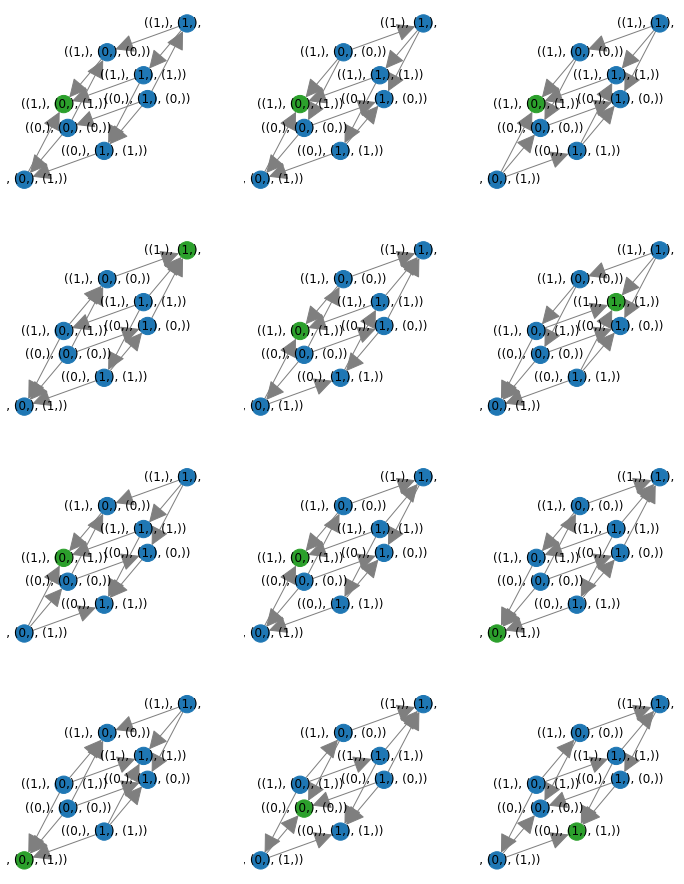

In [31]:
br_graph_space_sample = [br_graph_space[i] for i in np.random.choice(range(len(br_graph_space)), 12, replace=False)]
draw_br_graph_grid(br_graph_space_sample, jp_dict);

For this sample, we have the following relationship between the probability of convergence to team-optimality and the agents' inertia. (caution is good if relationship is monotone increasing)

12it [15:26, 77.22s/it] 


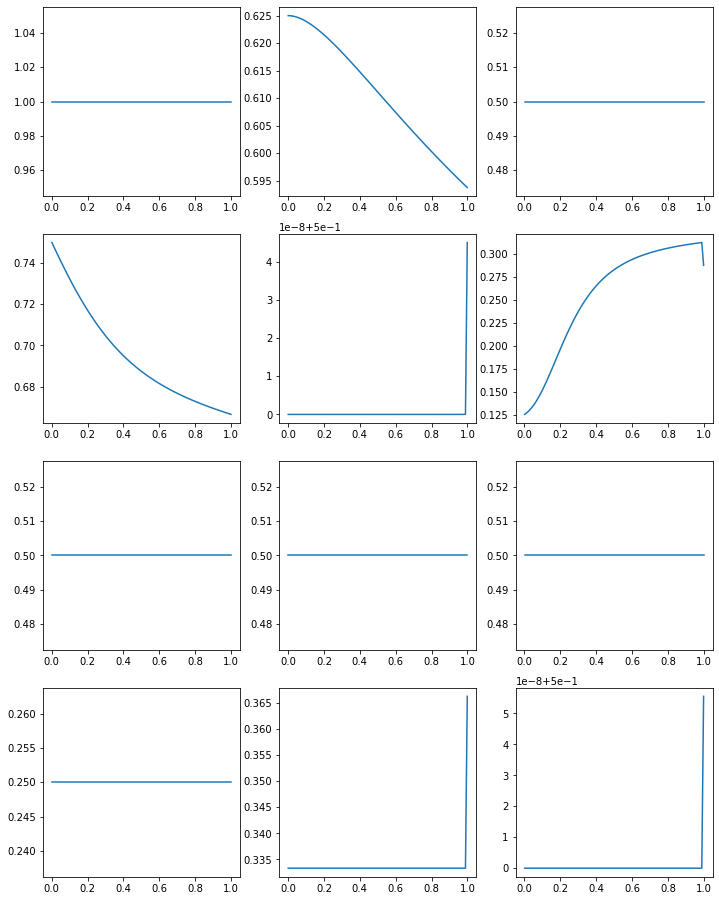

In [32]:
inv_jp_dict = {jp: ind for ind, jp in jp_dict.items()}

ncols = int(np.sqrt(len(br_graph_space_sample)))
nrows = len(br_graph_space_sample) // ncols + int((len(br_graph_space_sample) % ncols) > 0)
figsize = (ncols*4, nrows*4)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
axs = axs.ravel()

epsilon = 1e-3

for ax, (jp_order, br_graph) in tqdm(zip(axs, br_graph_space_sample)):
    team_opt_policy = jp_order[0]
    agent_inertias, team_opt_prob = get_team_opt_prob(team_opt_policy, br_graph, jp_dict, return_all=False)
    
    Lambdas = np.linspace(epsilon, 1 - epsilon, num=100)
    team_opt_probs = [team_opt_prob.subs(zip(agent_inertias, [l]*n_agents)) for l in Lambdas]
    
    ax.plot(Lambdas, team_opt_probs)


## 2-Agent repeated game with 3 actions

The number of best-reply graphs is $9!$. Again, even larger...

In [33]:
n_agents = 2
n_states = 1
n_actions = 3
n_Us = [n_actions] * n_agents # number of actions per agent (both agents have two actions)


agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))
jp_dict = {i: jp for i,jp in enumerate(joint_policy_space)}

We compute the best-reply graph space

In [34]:
br_graph_space = gen_br_graph_space(jp_dict)

362880it [01:27, 4147.86it/s]


And choose a random sample to study

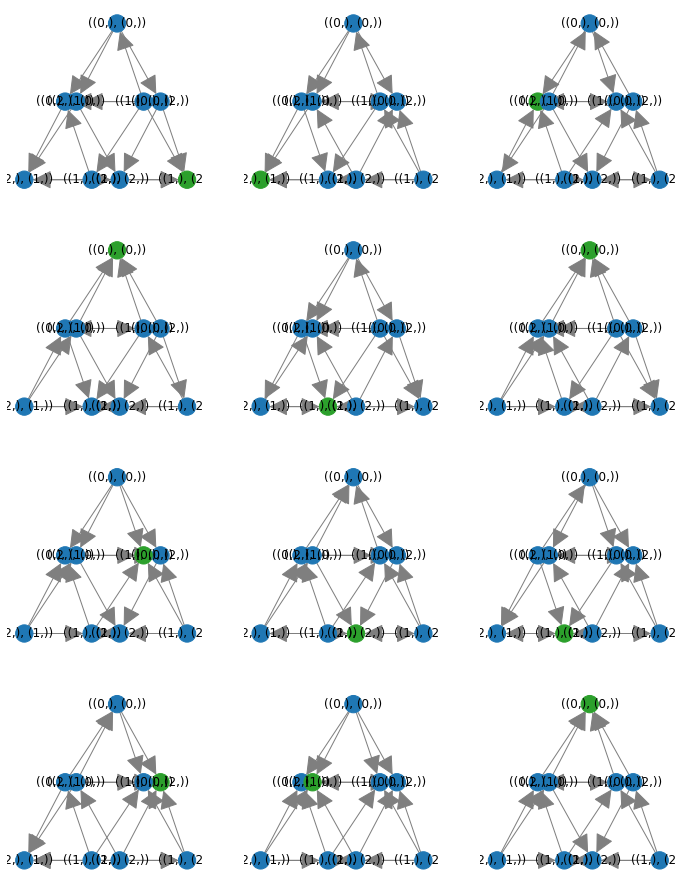

In [35]:
br_graph_space_sample = [br_graph_space[i] for i in np.random.choice(range(len(br_graph_space)), 12, replace=False)]
draw_br_graph_grid(br_graph_space_sample, jp_dict);

For this sample, we have the following relationship between the probability of convergence to team-optimality and the agents' inertia. (caution is good if relationship is monotone increasing)

12it [38:53, 194.43s/it]


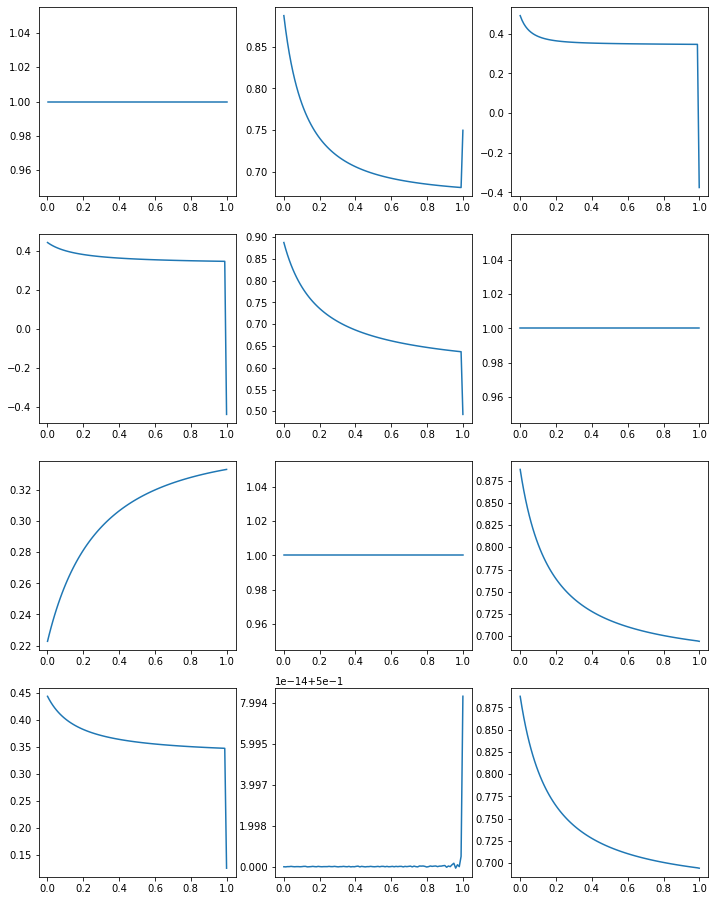

In [36]:
inv_jp_dict = {jp: ind for ind, jp in jp_dict.items()}

ncols = int(np.sqrt(len(br_graph_space_sample)))
nrows = len(br_graph_space_sample) // ncols + int((len(br_graph_space_sample) % ncols) > 0)
figsize = (ncols*4, nrows*4)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
axs = axs.ravel()

epsilon = 1e-3

for ax, (jp_order, br_graph) in tqdm(zip(axs, br_graph_space_sample)):
    team_opt_policy = jp_order[0]
    agent_inertias, team_opt_prob = get_team_opt_prob(team_opt_policy, br_graph, jp_dict, return_all=False)
    
    Lambdas = np.linspace(epsilon, 1 - epsilon, num=100)
    team_opt_probs = [team_opt_prob.subs(zip(agent_inertias, [l]*n_agents)) for l in Lambdas]
    
    ax.plot(Lambdas, team_opt_probs)


In [38]:
jp_order, br_graph = br_graph_space_sample[-2]

In [42]:
jp_order

[((2,), (0,)),
 ((0,), (2,)),
 ((0,), (1,)),
 ((1,), (0,)),
 ((2,), (2,)),
 ((1,), (1,)),
 ((1,), (2,)),
 ((0,), (0,)),
 ((2,), (1,))]

In [44]:
reward_matrix = np.zeros((3,3))
for reward, p in enumerate(jp_order):
    ((a0,), (a1,)) = p
    reward_matrix[a0][a1] = reward
reward_matrix

array([[7., 2., 1.],
       [3., 5., 6.],
       [0., 8., 4.]])

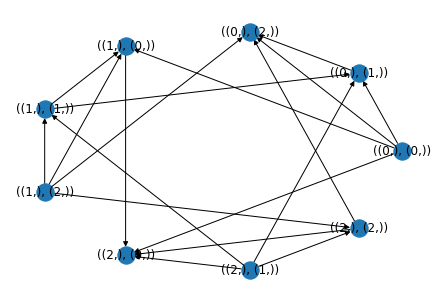

In [47]:
nx.draw_circular(br_graph, with_labels=True)

In [41]:
[inv_jp_dict[node] for node in br_graph.nodes if br_graph.out_degree(node) == 0]


[2, 6]

In [48]:
jp_dict[6]

((2,), (0,))